<a href="https://colab.research.google.com/github/theQuert/ml-notebooks/blob/master/DM21_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Q2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/MyDrive/NCCU/110_1/DM21/hw2_data

/content/drive/MyDrive/NCCU/110_1/DM21/hw2_data


In [3]:
%%capture
!pip3 install catboost

In [133]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

In [41]:
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('testing.csv')

In [42]:
X = train_df.loc[:, train_df.columns != 'Attrition']
y = train_df.iloc[:, 1:2]

In [31]:
# Normalization with DataFrame
# encoding: BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus
# standardscaler
# train_test_split

##### Encode string data with frequency encoding

In [43]:
X_enc = X.copy()
y_enc = y.copy()
frq_dis = X_enc.groupby('BusinessTravel').size()/len(X)
X_enc['BusinessTravel'] = X_enc['BusinessTravel'].map(frq_dis)

frq_dis = X_enc.groupby('Department').size()/len(X)
X_enc['Department'] = X_enc['Department'].map(frq_dis)

frq_dis = X_enc.groupby('EducationField').size()/len(X)
X_enc['EducationField'] = X_enc['EducationField'].map(frq_dis)

frq_dis = X_enc.groupby('Gender').size()/len(X)
X_enc['Gender'] = X_enc['Gender'].map(frq_dis)

frq_dis = X_enc.groupby('JobRole').size()/len(X)
X_enc['JobRole'] = X_enc['JobRole'].map(frq_dis)

frq_dis = X_enc.groupby('MaritalStatus').size()/len(X)
X_enc['MaritalStatus'] = X_enc['MaritalStatus'].map(frq_dis)
labelencoder = LabelEncoder()
y_enc['Attrition'] = labelencoder.fit_transform(y_enc['Attrition'])

In [44]:
# convert to values (ndarray) -> standardscaler -> train_test_split
X_arr = X_enc.iloc[:].values
y_arr = y_enc.iloc[:].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size = 0.2, random_state = 0)

In [11]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

Try to find useless features

In [ ]:
from catboost import Pool, EShapCalcType, EFeaturesSelectionAlgorithm

feature_names = ['F{}'.format(i) for i in range(X_train.shape[1])]
train_pool = Pool(X_train, y_train, feature_names=feature_names)
test_pool = Pool(X_test, y_test, feature_names=feature_names)

model = CatBoostClassifier(iterations=1000, random_seed=0)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-25',
    num_features_to_select=20,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

In [45]:
# Useless features indcies: [0, 5, 22, 24]
features = list(X)
exclude = {0, 5, 22, 24}
sel_features = [element for i, element in enumerate(features) if i not in exclude]

select  important features and reorganize the dataset

In [46]:
X_re = X_enc[sel_features]
X_arr = X_re.iloc[:].values
y_arr = y_enc.iloc[:].values
X_train_re, X_test_re, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.2, random_state=0)

In [47]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_re = sc_X.fit_transform(X_train_re)
X_test_re = sc_X.transform(X_test_re)
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

In [51]:
y_test_pro = []
y_pred_pro = []
def fit_predict(model):
    model.fit(X_train_re, y_train)
    y_pred = model.predict(X_test_re)
    corr = 0
    total = len(y_pred)
    for id in range(total):
        y_test_pro.append(round(y_test[id].item(0), 2))
        y_pred_pro.append(round(y_pred[id].item(0), 2))
    y_test_cmp = np.array([0 if x==-0.44 else 1 for x in y_test_pro])
    y_pred_cmp = np.array([1 if x==2.28 else 0 for x in y_pred_pro])

    print(f'Accuracy: {accuracy_score(y_test_cmp, y_pred_cmp)*100} %')
    print(f'Recall: {recall_score(y_test_cmp, y_pred_cmp)*100} %')
    print(f'Precision: {precision_score(y_test_cmp, y_pred_cmp)*100} %')
    print(f'F1 Score: {f1_score(y_test_cmp, y_pred_cmp)*100} %')

# {-0.44, 2.28}

In [ ]:
model = CatBoostClassifier(
                            iterations=6000,
                            loss_function='MultiClass',
                            eval_metric="WKappa",
                            task_type="GPU",
                            od_type="Iter",
                            early_stopping_rounds=600,
                            random_seed=43,
                            depth=3,
                            learning_rate=0.06,
                            l2_leaf_reg=3,
                            grow_policy='SymmetricTree',
                            bagging_temperature=1,
                            leaf_estimation_method='Newton',
                            fold_len_multiplier=2,
                              )

fit_predict(model)

In [ ]:
model = XGBClassifier(n_estimators=800, learning_rate= 0.03, max_depth=3, min_child_weight=6, booster='gbtree', gamma=0.1,
                             colsample_bytree=0.9, subsample=0.5, tree_method='gpu_hist', reg_alpha=0.1, reg_lambda=2)
fit_predict(model)

##### Train with training data, and validate with testing data instead of splitting testing from `train.csv`

In [54]:
# Training X, y
X = train_df.loc[:, train_df.columns != 'Attrition']
y = train_df.iloc[:, 1:2]
X_test = test_df.loc[:, train_df.columns != 'Attrition']
y_test = test_df.iloc[:, 1:2]

In [55]:
# frequency encoding
X_enc = X.copy()
y_enc = y.copy()
X_enc_test = X_test.copy()
y_enc_test = y_test.copy()

frq_dis = X_enc.groupby('BusinessTravel').size()/len(X)
X_enc['BusinessTravel'] = X_enc['BusinessTravel'].map(frq_dis)
X_enc_test['BusinessTravel'] = X_enc_test['BusinessTravel'].map(frq_dis)

frq_dis = X_enc.groupby('Department').size()/len(X)
X_enc['Department'] = X_enc['Department'].map(frq_dis)
X_enc_test['Department'] = X_enc_test['Department'].map(frq_dis)

frq_dis = X_enc.groupby('EducationField').size()/len(X)
X_enc['EducationField'] = X_enc['EducationField'].map(frq_dis)
X_enc_test['EducationField'] = X_enc_test['EducationField'].map(frq_dis)

frq_dis = X_enc.groupby('Gender').size()/len(X)
X_enc['Gender'] = X_enc['Gender'].map(frq_dis)
X_enc_test['Gender'] = X_enc_test['Gender'].map(frq_dis)

frq_dis = X_enc.groupby('JobRole').size()/len(X)
X_enc['JobRole'] = X_enc['JobRole'].map(frq_dis)
X_enc_test['JobRole'] = X_enc_test['JobRole'].map(frq_dis)

frq_dis = X_enc.groupby('MaritalStatus').size()/len(X)
X_enc['MaritalStatus'] = X_enc['MaritalStatus'].map(frq_dis)
X_enc_test['MaritalStatus'] = X_enc_test['MaritalStatus'].map(frq_dis)

labelencoder = LabelEncoder()
y_enc['Attrition'] = labelencoder.fit_transform(y_enc['Attrition'])
y_enc_test['Attrition'] = labelencoder.fit_transform(y_enc_test['Attrition'])

In [56]:
# convert to values (ndarray) -> standardscaler
X_train = X_enc.iloc[:].values
y_train = y_enc.iloc[:].values
X_test = X_enc_test.iloc[:].values
y_test = y_enc_test.iloc[:].values

In [57]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

process with selected features

In [58]:
# Remove 0, 5, 22, 24
features = list(X)
exclude = {0, 5, 22, 24}
sel_features = [element for i, element in enumerate(features) if i not in exclude]

In [59]:
X_re = X_enc[sel_features]
X_train = X_re.iloc[:].values
y_train = y_enc.iloc[:].values
X_test_re = X_enc_test[sel_features]
X_test = X_test_re.iloc[:].values
y_test = y_enc_test.iloc[:].values
# X_train_re, X_test_re, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.2, random_state=0)

In [60]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_re = sc_X.fit_transform(X_train)
X_test_re = sc_X.transform(X_test)
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

In [ ]:
model = CatBoostClassifier(
                            iterations=6000,
                            loss_function='MultiClass',
                            eval_metric="WKappa",
                            task_type="GPU",
                            od_type="Iter",
                            early_stopping_rounds=600,
                            random_seed=43,
                            depth=3,
                            learning_rate=0.06,
                            l2_leaf_reg=3,
                            grow_policy='SymmetricTree',
                            bagging_temperature=1,
                            leaf_estimation_method='Newton',
                            fold_len_multiplier=2,
                              )

fit_predict(model)


In [102]:
model = CatBoostClassifier()
fit_predict(model)

Learning rate set to 0.011045
0:	learn: 0.6859814	total: 5.02ms	remaining: 5.02s
1:	learn: 0.6782205	total: 6.55ms	remaining: 3.27s
2:	learn: 0.6706276	total: 7.91ms	remaining: 2.63s
3:	learn: 0.6634920	total: 9.33ms	remaining: 2.32s
4:	learn: 0.6566025	total: 10.7ms	remaining: 2.13s
5:	learn: 0.6500627	total: 12ms	remaining: 1.99s
6:	learn: 0.6437156	total: 13.3ms	remaining: 1.89s
7:	learn: 0.6379599	total: 14.6ms	remaining: 1.81s
8:	learn: 0.6307448	total: 15.9ms	remaining: 1.75s
9:	learn: 0.6248458	total: 17.2ms	remaining: 1.71s
10:	learn: 0.6196978	total: 18.5ms	remaining: 1.66s
11:	learn: 0.6134429	total: 19.8ms	remaining: 1.63s
12:	learn: 0.6076427	total: 21.1ms	remaining: 1.6s
13:	learn: 0.6021050	total: 22.4ms	remaining: 1.58s
14:	learn: 0.5968450	total: 23.7ms	remaining: 1.55s
15:	learn: 0.5919891	total: 24.5ms	remaining: 1.5s
16:	learn: 0.5860672	total: 25.7ms	remaining: 1.49s
17:	learn: 0.5813477	total: 27ms	remaining: 1.47s
18:	learn: 0.5762679	total: 28.3ms	remaining: 1.46

In [62]:
model = XGBClassifier(n_estimators=800, learning_rate= 0.03, max_depth=3, min_child_weight=6, booster='gbtree', gamma=0.1,
                             colsample_bytree=0.9, subsample=0.5, tree_method='gpu_hist', reg_alpha=0.1, reg_lambda=2)
fit_predict(model)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 47.63705103969754 %
Recall: 3.8869257950530036 %
Precision: 68.75 %
F1 Score: 7.357859531772575 %


train with selected features cannot improve the performance, we use all features as below

#### Apply SMOTE to oversampling data, and using with all features

In [105]:
# Training X, y
X = train_df.loc[:, train_df.columns != 'Attrition']
y = train_df.iloc[:, 1:2]
X_test = test_df.loc[:, train_df.columns != 'Attrition']
y_test = test_df.iloc[:, 1:2]

In [106]:
# frequency encoding
X_enc = X.copy()
y_enc = y.copy()
X_enc_test = X_test.copy()
y_enc_test = y_test.copy()

frq_dis = X_enc.groupby('BusinessTravel').size()/len(X)
X_enc['BusinessTravel'] = X_enc['BusinessTravel'].map(frq_dis)
X_enc_test['BusinessTravel'] = X_enc_test['BusinessTravel'].map(frq_dis)

frq_dis = X_enc.groupby('Department').size()/len(X)
X_enc['Department'] = X_enc['Department'].map(frq_dis)
X_enc_test['Department'] = X_enc_test['Department'].map(frq_dis)

frq_dis = X_enc.groupby('EducationField').size()/len(X)
X_enc['EducationField'] = X_enc['EducationField'].map(frq_dis)
X_enc_test['EducationField'] = X_enc_test['EducationField'].map(frq_dis)

frq_dis = X_enc.groupby('Gender').size()/len(X)
X_enc['Gender'] = X_enc['Gender'].map(frq_dis)
X_enc_test['Gender'] = X_enc_test['Gender'].map(frq_dis)

frq_dis = X_enc.groupby('JobRole').size()/len(X)
X_enc['JobRole'] = X_enc['JobRole'].map(frq_dis)
X_enc_test['JobRole'] = X_enc_test['JobRole'].map(frq_dis)

frq_dis = X_enc.groupby('MaritalStatus').size()/len(X)
X_enc['MaritalStatus'] = X_enc['MaritalStatus'].map(frq_dis)
X_enc_test['MaritalStatus'] = X_enc_test['MaritalStatus'].map(frq_dis)

labelencoder = LabelEncoder()
y_enc['Attrition'] = labelencoder.fit_transform(y_enc['Attrition'])
y_enc_test['Attrition'] = labelencoder.fit_transform(y_enc_test['Attrition'])

In [107]:
# convert to values (ndarray) -> standardscaler
X_train = X_enc.iloc[:].values
y_train = y_enc.iloc[:].values
X_test = X_enc_test.iloc[:].values
y_test = y_enc_test.iloc[:].values

In [108]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_re = sc_X.fit_transform(X_train)
X_test_re = sc_X.transform(X_test)
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

In [109]:
from imblearn.combine import SMOTETomek

smtom = SMOTETomek(random_state=42)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train_re, y_train.astype('int'))

In [121]:
y_test_pro = []
y_pred_pro = []
def fit_predict(model):
    model.fit(X_train_smtom, y_train_smtom)
    y_pred = model.predict(X_test_re)
    y_test_pro = []
    y_pred_pro = []
    corr = 0
    total = len(y_pred)
    for id in range(total):
        y_test_pro.append(round(y_test[id].item(0), 2))
        y_pred_pro.append(round(y_pred[id].item(0), 2))
    y_test_cmp = np.array([0 if x==-0.44 else 1 for x in y_test_pro])
    y_pred_cmp = np.array([1 if x==2 else 0 for x in y_pred_pro])
    print(f'Accuracy: {accuracy_score(y_test_cmp, y_pred_cmp)*100} %')
    print(f'Recall: {recall_score(y_test_cmp, y_pred_cmp)*100} %')
    print(f'Precision: {precision_score(y_test_cmp, y_pred_cmp)*100} %')
    print(f'F1 Score: {f1_score(y_test_cmp, y_pred_cmp)*100} %')
    return y_test_cmp, y_pred_cmp
# {-0.44, 2.28}

Learning rate set to 0.013774
0:	learn: 0.6869425	total: 9.9ms	remaining: 9.89s
1:	learn: 0.6791533	total: 17.1ms	remaining: 8.53s
2:	learn: 0.6718190	total: 24.3ms	remaining: 8.09s
3:	learn: 0.6645662	total: 31.6ms	remaining: 7.87s
4:	learn: 0.6585326	total: 38.8ms	remaining: 7.72s
5:	learn: 0.6521027	total: 46.1ms	remaining: 7.63s
6:	learn: 0.6444904	total: 57.3ms	remaining: 8.13s
7:	learn: 0.6378667	total: 68.3ms	remaining: 8.46s
8:	learn: 0.6313972	total: 75.4ms	remaining: 8.3s
9:	learn: 0.6264013	total: 82.5ms	remaining: 8.17s
10:	learn: 0.6205113	total: 90ms	remaining: 8.09s
11:	learn: 0.6145611	total: 97ms	remaining: 7.99s
12:	learn: 0.6091497	total: 103ms	remaining: 7.82s
13:	learn: 0.6034782	total: 109ms	remaining: 7.7s
14:	learn: 0.5982000	total: 115ms	remaining: 7.57s
15:	learn: 0.5932162	total: 121ms	remaining: 7.46s
16:	learn: 0.5879582	total: 128ms	remaining: 7.4s
17:	learn: 0.5842675	total: 134ms	remaining: 7.3s
18:	learn: 0.5792400	total: 140ms	remaining: 7.21s
19:	lear

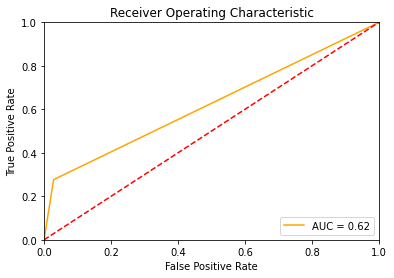

In [134]:
model = CatBoostClassifier()
y_test_cmp, y_pred_cmp = fit_predict(model)
fpr, tpr, threshold = roc_curve(y_test_cmp, y_pred_cmp)
auc1 = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy: 86.3481228668942 %
Recall: 36.17021276595745 %
Precision: 62.96296296296296 %
F1 Score: 45.94594594594595 %


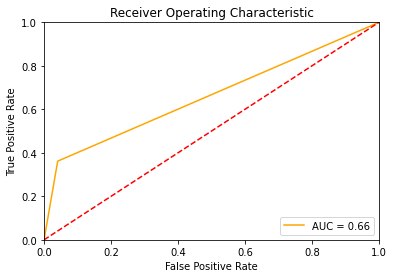

In [135]:
model = XGBClassifier(n_estimators=800, learning_rate= 0.03, max_depth=3, min_child_weight=6, booster='gbtree', gamma=0.1,
                             colsample_bytree=0.9, subsample=0.5, tree_method='gpu_hist', reg_alpha=0.1, reg_lambda=2)
y_test_cmp, y_pred_cmp = fit_predict(model)
fpr, tpr, threshold = roc_curve(y_test_cmp, y_pred_cmp)
auc1 = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy: 79.18088737201366 %
Recall: 40.42553191489361 %
Precision: 36.53846153846153 %
F1 Score: 38.38383838383838 %


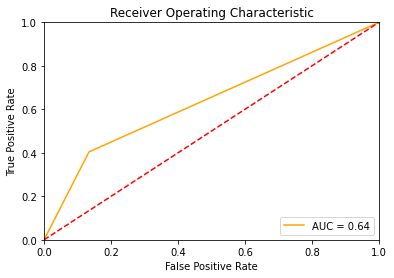

In [136]:
model = SVC(kernel='rbf', random_state=42)
y_test_cmp, y_pred_cmp = fit_predict(model)
fpr, tpr, threshold = roc_curve(y_test_cmp, y_pred_cmp)
auc1 = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy: 67.91808873720136 %
Recall: 68.08510638297872 %
Precision: 28.82882882882883 %
F1 Score: 40.50632911392405 %


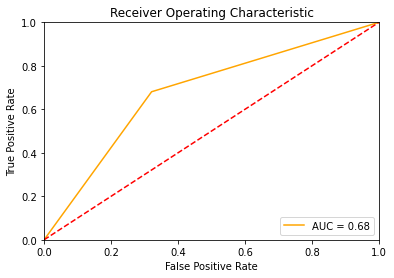

In [137]:
model = SVC(kernel='linear', random_state=42)
y_test_cmp, y_pred_cmp = fit_predict(model)
fpr, tpr, threshold = roc_curve(y_test_cmp, y_pred_cmp)
auc1 = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy: 78.839590443686 %
Recall: 51.06382978723404 %
Precision: 38.095238095238095 %
F1 Score: 43.63636363636363 %


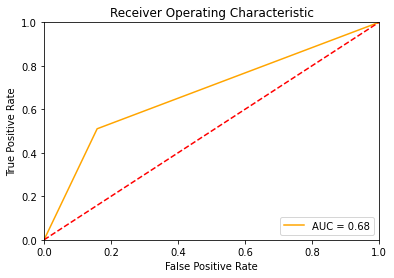

In [139]:
model = SVC(kernel='poly', random_state=42)
y_test_cmp, y_pred_cmp = fit_predict(model)
fpr, tpr, threshold = roc_curve(y_test_cmp, y_pred_cmp)
auc1 = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy: 65.18771331058021 %
Recall: 63.829787234042556 %
Precision: 26.08695652173913 %
F1 Score: 37.03703703703704 %


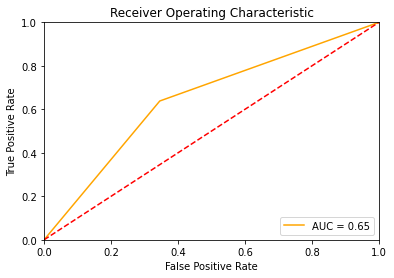

In [140]:
model = SVC(kernel='sigmoid', random_state=42)
y_test_cmp, y_pred_cmp = fit_predict(model)
fpr, tpr, threshold = roc_curve(y_test_cmp, y_pred_cmp)
auc1 = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

we implement model including `CatBoostClassifier`, `XGBClassifier`, `SVM`
according to the AUC, SVM with kernel `linear`, `poly` perform better